<font color='red'>  
# Please note this analysis is not intended to imply anything about any police department or to make any kind of statement on this issue. The purpose of this script is to demonstrate competencies in Python and statistics I have learned through coursework and independent learning. I do not know the source of the data as this was provided to me from a teacher for a final project. This is for demonstration purposes only as part of a project portfolio.

</font>

<hr style="height:2px;border-width:0;color:gray;background-color:gray">

# Topic - Does gender affect a police officer's decision to citate a driver for speeding?

### I will be applying Chi-Square analysis to answer the question.

### Chi-square analysis is an effective tool to determine if categorical variables are dependent or independent by comparing cross tabulations of expected and observed frequencies. This study will use a 2x2 contingency table (Male and Female) vs (Citated and Not Citated).

### The key concept for the analysis is the condition of independence. Two events are independent if the  intersection of Events A and B equals the probability of A times the probability of B. Each cell in a contingency table is an intersection of two events. Therefore, you can calculate the probability of each cell by multiplying the row total by the column total divided by the square of N (size of the population). The expected frequency for a given cell can then be calculated by multiplying the probability by N. The expected frequency can also be calculated in one step by multiplying the row total by the column total then dividing by N.

### Another technique to test for independence is to compare the difference in proportions of men and women receiving tickets.  If the confidence interval includes zero, you can conclude the events are independent and therefore provide a confirmation of the chi-square analysis.  I have included this analysis as well in the script.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import researchpy as rp
import math
import re

# Data Import and Cleaning

In [2]:
data = pd.read_csv('police.csv')
data.head()

,state,stop_date,stop_time,county_name,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district
0,RI,1/4/2005,12:55,NaN,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4
1,RI,1/23/2005,23:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
2,RI,2/17/2005,4:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4
3,RI,2/20/2005,17:15,NaN,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1
4,RI,2/24/2005,1:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3


In [3]:
# Performing some general data cleaning to the data

# Replacing empty strings or strings with only spaces with NaN
data = data.replace(r'^\s*$', np.nan, regex=True)

# Stripping leading and trailing spaces
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Converting strings to upper case to ensure consistency
data = data.apply(lambda x: x.astype(str).str.upper())

# Converting all column headers to upper case
data.columns = data.columns.str.upper()

In [4]:
data.head()

,STATE,STOP_DATE,STOP_TIME,COUNTY_NAME,DRIVER_GENDER,DRIVER_RACE,VIOLATION_RAW,VIOLATION,SEARCH_CONDUCTED,SEARCH_TYPE,STOP_OUTCOME,IS_ARRESTED,STOP_DURATION,DRUGS_RELATED_STOP,DISTRICT
0,RI,1/4/2005,12:55,NAN,M,WHITE,EQUIPMENT/INSPECTION VIOLATION,EQUIPMENT,FALSE,NAN,CITATION,FALSE,0-15 MIN,FALSE,ZONE X4
1,RI,1/23/2005,23:15,NAN,M,WHITE,SPEEDING,SPEEDING,FALSE,NAN,CITATION,FALSE,0-15 MIN,FALSE,ZONE K3
2,RI,2/17/2005,4:15,NAN,M,WHITE,SPEEDING,SPEEDING,FALSE,NAN,CITATION,FALSE,0-15 MIN,FALSE,ZONE X4
3,RI,2/20/2005,17:15,NAN,M,WHITE,CALL FOR SERVICE,OTHER,FALSE,NAN,ARREST DRIVER,TRUE,16-30 MIN,FALSE,ZONE X1
4,RI,2/24/2005,1:20,NAN,F,WHITE,SPEEDING,SPEEDING,FALSE,NAN,CITATION,FALSE,0-15 MIN,FALSE,ZONE X3


In [5]:
# Looking at unique entries in Violation column
data['VIOLATION'].unique()

array(['EQUIPMENT', 'SPEEDING', 'OTHER', 'NAN', 'MOVING VIOLATION',
       'REGISTRATION/PLATES', 'SEAT BELT'], dtype=object)

In [6]:
# I am only interested in speeding violations, so I will extract all speeding records
# and see how many speeding records exist.
# I also want to see the unique entries in the driver_gender column.
speedingdata = data[data['VIOLATION'] == 'SPEEDING']
print(speedingdata['VIOLATION'].unique())
print(len(speedingdata))
print(speedingdata['DRIVER_GENDER'].unique())

['SPEEDING']
48424
['M' 'F' 'NAN']


In [7]:
speedingdata.groupby(['DRIVER_GENDER'])['DRIVER_GENDER'].count()

DRIVER_GENDER
F      15646
M      32777
NAN        1
Name: DRIVER_GENDER, dtype: int64

In [8]:
# I want to see all the unique combinations of stop_outcome, search_conducted, is_arrested, and drugs_related_stop along
# with counts of each combination.
speedingdata.groupby(['STOP_OUTCOME','SEARCH_CONDUCTED','IS_ARRESTED',
              'DRUGS_RELATED_STOP']).size().reset_index().rename(columns={0:'COUNT'})

,STOP_OUTCOME,SEARCH_CONDUCTED,IS_ARRESTED,DRUGS_RELATED_STOP,COUNT
0,ARREST DRIVER,FALSE,TRUE,FALSE,340
1,ARREST DRIVER,TRUE,TRUE,FALSE,213
2,ARREST DRIVER,TRUE,TRUE,TRUE,58
3,ARREST PASSENGER,FALSE,TRUE,FALSE,27
4,ARREST PASSENGER,TRUE,TRUE,FALSE,13
5,ARREST PASSENGER,TRUE,TRUE,TRUE,12
6,CITATION,FALSE,FALSE,FALSE,45141
7,CITATION,TRUE,FALSE,FALSE,504
8,CITATION,TRUE,FALSE,TRUE,215
9,N/D,FALSE,FALSE,FALSE,47


# Data Selection Criteria
## The purpose of selection is to isolate records where other violations could introduce bias in the stop outcome. The scope is to focus on speeding related offenses.

### 1. Passenger arrests and unknown outcomes ('N/D') will be excluded. 
### 2. I will exclude records where the driver's gender is unknown (only 1 record so no need to impute).
### 3. I will exclude records if a search was conducted or the stop was drug related.

# Citation Result Grouping

### I will create a 'Citated?' column to group the stop outcomes.
### 1. 'YES' entries for driver arrests and citations.
### 2. 'NO' entries for no action and warnings.

In [9]:
# Setting up a filter for the conditions listed above
outcomes = ~speedingdata['STOP_OUTCOME'].isin(['ARREST PASSENGER','N/D'])
gender = speedingdata['DRIVER_GENDER'].isin(['M','F'])
not_drug_stop = speedingdata['DRUGS_RELATED_STOP'] == 'FALSE'
not_searched = speedingdata['SEARCH_CONDUCTED'] == 'FALSE'

# Using the filters to extract the desired data
FinalData = speedingdata.loc[outcomes & gender & not_drug_stop & not_searched].copy()

In [10]:
# Checking the filtering
FinalData.groupby(['DRIVER_GENDER','STOP_OUTCOME','SEARCH_CONDUCTED','IS_ARRESTED',
              'DRUGS_RELATED_STOP']).size().reset_index().rename(columns={0:'COUNT'})

,DRIVER_GENDER,STOP_OUTCOME,SEARCH_CONDUCTED,IS_ARRESTED,DRUGS_RELATED_STOP,COUNT
0,F,ARREST DRIVER,FALSE,TRUE,FALSE,61
1,F,CITATION,FALSE,FALSE,FALSE,14804
2,F,NO ACTION,FALSE,FALSE,FALSE,5
3,F,WARNING,FALSE,FALSE,FALSE,626
4,M,ARREST DRIVER,FALSE,TRUE,FALSE,279
5,M,CITATION,FALSE,FALSE,FALSE,30336
6,M,NO ACTION,FALSE,FALSE,FALSE,28
7,M,WARNING,FALSE,FALSE,FALSE,1166


In [11]:
# Binning the data
FinalData.loc[FinalData['STOP_OUTCOME'].isin(['ARREST DRIVER','CITATION']), 'CITATED?'] = 'YES'
FinalData.loc[~FinalData['STOP_OUTCOME'].isin(['ARREST DRIVER','CITATION']), 'CITATED?'] = 'NO'

# Contingency Tables 

In [12]:
# Building contingency table using crosstab
contingency_table = pd.crosstab(FinalData['DRIVER_GENDER'],FinalData['CITATED?'],
                                margins=True)
contingency_table

CITATED?,NO,YES,All
DRIVER_GENDER,,,
F,631,14865,15496
M,1194,30615,31809
All,1825,45480,47305


In [13]:
# Building an expected frequency table
exp_freq = contingency_table.copy()
exp_freq.iloc[0,0] = exp_freq.iloc[0,2]*exp_freq.iloc[2,0]/exp_freq.iloc[2,2]
exp_freq.iloc[0,1] = exp_freq.iloc[0,2]*exp_freq.iloc[2,1]/exp_freq.iloc[2,2]
exp_freq.iloc[1,0] = exp_freq.iloc[1,2]*exp_freq.iloc[2,0]/exp_freq.iloc[2,2]
exp_freq.iloc[1,1] = exp_freq.iloc[1,2]*exp_freq.iloc[2,1]/exp_freq.iloc[2,2]
exp_freq.round(0)

CITATED?,NO,YES,All
DRIVER_GENDER,,,
F,598.0,14898.0,15496
M,1227.0,30582.0,31809
All,1825.0,45480.0,47305


### You can see the values in both observed and expected frequencies are close.  This could be a signal that the data will show a lack of bias on citation rates based on gender, but we must run a statistical test to prove it.

# Data Analysis - Chi-Square Test

### ResearchPy has a simple method to perform Pearson chi-square analysis with pandas crosstab function

#### Refer to https://researchpy.readthedocs.io/en/latest/crosstab_documentation.html

### I will test at 95% confidence, therefore alpha = 0.05.

### Null Hypothesis: The two classifications are independent (ticketing is not gender biased).

### Alternative hypothesis: The two classifications are dependent (ticketing is gender biased).

In [14]:
cont_table_prop, stats, exp_freq = rp.crosstab(FinalData['DRIVER_GENDER'],FinalData['CITATED?'],
                                          prop='col',test='chi-square',expected_freqs=True) 

In [15]:
print(cont_table_prop)

              CITATED?                
CITATED?            NO     YES     All
DRIVER_GENDER                         
F                34.58   32.68   32.76
M                65.42   67.32   67.24
All             100.00  100.00  100.00


In [16]:
print("Observed Frequencies\n\n",contingency_table,"\n")
print("Expected Frequencies\n\n",exp_freq.round(),"\n")
print("Results\n\n",stats)

Observed Frequencies

 CITATED?         NO    YES    All
DRIVER_GENDER                    
F               631  14865  15496
M              1194  30615  31809
All            1825  45480  47305 

Expected Frequencies

               CITATED?         
CITATED?            NO      YES
DRIVER_GENDER                  
F                598.0  14898.0
M               1227.0  30582.0 

Results

                 Chi-square test  results
0  Pearson Chi-square ( 1.0) =    2.8474
1                    p-value =    0.0915
2               Cramer's phi =    0.0078


### The contingency tables match the manual method and the p-value is 0.0915. We fail to reject the null hypothesis and can conclude that gender did not impact the decision to citate the driver.

### I will now construct a stacked bar chart to visualize the test results. I will use the table with the proportions to create the chart.

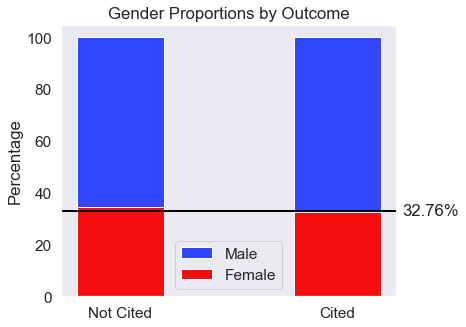

In [17]:
# References - https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.bar.html
# https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.legend.html
# https://seaborn.pydata.org/generated/seaborn.set.html
# https://matplotlib.org/2.1.0/api/_as_gen/matplotlib.pyplot.axhline.html
# https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.ylabel.html?highlight=ylabel#matplotlib.pyplot.ylabel
# https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.title.html?highlight=title#matplotlib.pyplot.title
# https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.show.html?highlight=show#matplotlib.pyplot.show
# https://matplotlib.org/2.1.0/api/text_api.html?highlight=text#module-matplotlib.text

# Extracting the female data for the chart
female = cont_table_prop.iloc[0][0:2]

# Extracting the male data for the chart
male = cont_table_prop.iloc[1][0:2]

# Setting up the x-axis coordinates of the bars - using the outcome in this case to label the bars
# on the x axis and placing in a list of x
x = ["Not Cited", "Cited"]

# Setting the size of the plot
fig = plt.figure(figsize=(6,5))

# Setting a font scale and a dark style that will not include gridlines
sns.set(font_scale=1.4, style='dark')

# Plotting bars with female data in a red color.
plt1 = plt.bar(x, female, 0.4, color ='#F40E0B')

# Plotting bars for male data in a blue color. Using the bottom parameter to define the y-axis coordinate for
# the bottom of the bar. The bottom in this case is the top of the bar representing female data.
plt2 = plt.bar(x, male, 0.4, bottom=female, color = '#3346FF')

# Adding a horizontal reference line that represents the height at which the bars should change from 
# female to male data in the case of independence - 32.76% in this case
plt3 = plt.axhline(y=cont_table_prop.iloc[0][-1],linestyle='-',color='black',linewidth=2.0)

# Adding a label to the reference line
plt.text(1.3,31.5,str(cont_table_prop.iloc[0][-1])+"%")

# Adding the legend
plt.legend((plt2[0], plt1[0]),('Male','Female'))

# Adding label for y-axis
plt.ylabel('Percentage')

# Adding a title to the chart
plt.title('Gender Proportions by Outcome')

# Displaying the result
plt.show()

### The bar chart visually displays the results in terms of proportions for each outcome. The top of the female bar would be at the level of the reference line for both outcomes in the case of independence (or lack of gender bias). You can see the data is a close fit.

# Alternative Approach - Comparison of two population proportions

### I am now going to test for independence by calculating a confidence interval of the difference in two population proportions.

### I will test at 95% confidence to match conditions in the Chi-square analysis.

### Population 1 = women pulled over for speeding

### Population 2 = men pulled over for speeding

### Null hypothesis: p1 - p2 equals zero (citations are not gender biased)

### Alternative hypothesis: p1 - p2 does not equal zero (citations are gender biased)

### This test will agree with the Chi-square analysis if the confidence interval includes zero.

In [18]:
# Creating a function to calculate the confidence interval
def pop_prop_diff_ci(p1, p2, n1, n2, z):
    q1 = 1 - p1
    q2 = 1 - p2
    diff = p1 - p2
    stderr1 = p1 * q1 / n1
    stderr2 = p2 * q2 / n2
    dev_range = z * math.sqrt(stderr1 + stderr2)
    lower = diff - dev_range
    upper = diff + dev_range
    return (lower,upper)

In [19]:
contingency_table

CITATED?,NO,YES,All
DRIVER_GENDER,,,
F,631,14865,15496
M,1194,30615,31809
All,1825,45480,47305


In [20]:
# I am calculating the "Success" rate for each population (Receiving a citation in this case)
# This is achieved by dividing the number of a gender that is ticketed ("YES") column value and
# dividing it by the gender total (row total in "All" column)
# z = 1.96 as alpha is 0.05 and test is two-tailed

p1 = contingency_table.iloc[0,1] / contingency_table.iloc[0,2]
p2 = contingency_table.iloc[1,1] / contingency_table.iloc[1,2]
n1 = contingency_table.iloc[0,2]
n2 = contingency_table.iloc[1,2]

z = 1.96

print("The confidence interval is",pop_prop_diff_ci(p1, p2, n1, n2, z))

The confidence interval is (-0.006931571710294895, 0.0005642925224513731)


### The confidence interval includes zero and therefore we fail to reject the null hypothesis and conclude gender does not impact the decision to ticket a driver for speeding.  The result agrees with the Chi-square analysis.